# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ S4B
+ S4C

#### Archives:
+ Transcription_low-chromatin-DNA.yama
+ Transcription_high-chromatin-DNA.yama
+ Photobleaching_low-chromatin-DNA.yama
+ Transcription_low-chromatin-licensed-DNA_ATP_1.yama
+ Transcription_low-chromatin-licensed-DNA_ATP_2.yama
+ Transcription_high-chromatin-licensed-DNA_ATP.yama
+ Transcription_low-chromatin-licensed-DNA_ATPgS.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_low-chromatin-DNA.yama',
                     'Transcription_high-chromatin-DNA.yama',
                     'Photobleaching_low-chromatin-DNA.yama',
                     'Transcription_low-chromatin-licensed-DNA_ATP_1.yama',
                     'Transcription_low-chromatin-licensed-DNA_ATP_2.yama',
                     'Transcription_high-chromatin-licensed-DNA_ATP.yama',
                     'Transcription_low-chromatin-licensed-DNA_ATPgS.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure4/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure4/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

nucleotide not found. Setting default to n/a
cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_low-chromatin-DNA,3,470,LD555-H3-NUC; ybbR-LD655-T7,ATP,False,50x,False,passed
Transcription_high-chromatin-DNA,1,180,LD555-H3-NUC; ybbR-LD655-T7,ATP,False,75x,False,passed
Photobleaching_low-chromatin-DNA,1,200,LD555-H3-NUC,n/a,False,50x,False,passed
Transcription_low-chromatin-licensed-DNA_ATP_1,4,85,SNAP-AF488-T7; LD555-H3-NUC; ybbR-LD655-MCM,ATP,False,50x,False,passed
Transcription_low-chromatin-licensed-DNA_ATP_2,4,37,SNAP-AF488-T7; LD555-H3-NUC; ybbR-LD655-MCM,ATP,False,50x,False,passed
Transcription_high-chromatin-licensed-DNA_ATP,4,49,SNAP-AF488-T7; LD555-H3-NUC; ybbR-LD655-MCM,ATP,False,75x,False,passed
Transcription_low-chromatin-licensed-DNA_ATPgS,4,73,SNAP-AF488-T7; LD555-H3-NUC; ybbR-LD655-MCM,ATPgS,False,50x,False,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(MCM_1_, initial_intensity, ), (MCM_1_, lifetime, ), (MCM_1_, number_pauses, ), (MCM_1_, start_site, ), (MCM_1_, stop_site, ), (MCM_2_, initial_intensity, ), (MCM_2_, lifetime, ), (MCM_2_, number_pauses, ), (MCM_2_, start_site, ), (MCM_2_, stop_site, ), (NUC_1_, initial_intensity, ), (NUC_1_, lifetime, ), (NUC_1_, number_pauses, ), (NUC_1_, start_site, ), (NUC_1_, stop_site, ), (NUC_2_, initial_intensity, ), (NUC_2_, lifetime, ), (NUC_2_, number_pauses, ), (NUC_2_, start_site, ), (NUC_2_, stop_site, ), (NUC_3_, initial_intensity, ), (NUC_3_, lifetime, ), (NUC_3_, number_pauses, ), (NUC_3_, start_site, ), (NUC_3_, stop_site, ), (NUC_4_, initial_intensity, ), (NUC_4_, lifetime, ), (NUC_4_, number_pauses, ), (NUC_4_, start_site, ), (NUC_4_, stop_site, ), (NUC_5_, initial_intensity, ), (NUC_5_, lifetime, ), (NUC_5_, number_pauses, ), (NUC_5_, start_site, ), (NUC_5_, stop_site, ), (NUC_6_, initial_intensity, ), (NUC_6_, lifetime, ), (NUC_6_, number_pauses, ), (NUC_6_, start_site, ), (NUC_6_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

[0 rows x 45 columns]

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'chromatin'] = archive.chromatin
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:10][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            else:
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()


# fill all NaN values in number_protein with 0
proteins = set()
for archive in DnaMoleculeArchive.instances:
    proteins.update(archive.proteins)

for protein in proteins:
    df['number_'+protein] = df['number_'+protein].apply(lambda value: 0 if np.isnan(value) else value)
    
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


In [13]:
df.head()

molecule                          MCM_1_                                    \
properties             initial_intensity lifetime number_pauses start_site   
properties_details                                                           
oumBTp4C7jaaCrUonxFBfz               NaN      NaN           NaN        NaN   
tBFZqXqxoeQGSB67GRfaGb               NaN      NaN           NaN        NaN   
kAfDXrSuUFGknUjZV36oa7               NaN      NaN           NaN        NaN   
8hqAtVir9BRdkggTDzH5rR               NaN      NaN           NaN        NaN   
qGG7u2416k1edXZycFfp96               NaN      NaN           NaN        NaN   

molecule                                    MCM_2_                         \
properties             stop_site initial_intensity lifetime number_pauses   
properties_details                                                          
oumBTp4C7jaaCrUonxFBfz       NaN               NaN      NaN           NaN   
tBFZqXqxoeQGSB67GRfaGb       NaN               NaN      NaN           NaN   
kAfDXrSuUFGknUjZV36oa7       NaN               NaN      NaN           NaN   
8hqAtVir9BRdkggTDzH5rR       NaN               NaN      NaN           NaN   
qGG7u2416k1edXZycFfp96       NaN               NaN      NaN           NaN   

molecule                                     ... dna_length hs_wash label_MCM  \
properties             start_site stop_site  ...                                
properties_details                           ...                                
oumBTp4C7jaaCrUonxFBfz        NaN       NaN  ...  34.910086   False       NaN   
tBFZqXqxoeQGSB67GRfaGb        NaN       NaN  ...  34.699449   False       NaN   
kAfDXrSuUFGknUjZV36oa7        NaN       NaN  ...  33.935650   False       NaN   
8hqAtVir9BRdkggTDzH5rR        NaN       NaN  ...  33.569068   False       NaN   
qGG7u2416k1edXZycFfp96        NaN       NaN  ...  34.847473   False       NaN   

molecule               label_NUC    label_T7 nucleotide number_MCM number_NUC  \
properties                                                                      
properties_details                                                              
oumBTp4C7jaaCrUonxFBfz  LD555-H3  ybbR-LD655        ATP        0.0        1.0   
tBFZqXqxoeQGSB67GRfaGb  LD555-H3  ybbR-LD655        ATP        0.0        1.0   
kAfDXrSuUFGknUjZV36oa7  LD555-H3  ybbR-LD655        ATP        0.0        1.0   
8hqAtVir9BRdkggTDzH5rR  LD555-H3  ybbR-LD655        ATP        0.0        1.0   
qGG7u2416k1edXZycFfp96  LD555-H3  ybbR-LD655        ATP        0.0        2.0   

molecule               number_T7  \
properties                         
properties_details                 
oumBTp4C7jaaCrUonxFBfz       0.0   
tBFZqXqxoeQGSB67GRfaGb       0.0   
kAfDXrSuUFGknUjZV36oa7       0.0   
8hqAtVir9BRdkggTDzH5rR       1.0   
qGG7u2416k1edXZycFfp96       0.0   

molecule                                                             tags  
properties                                                                 
properties_details                                                         
oumBTp4C7jaaCrUonxFBfz                                           [accept]  
tBFZqXqxoeQGSB67GRfaGb                               [accept, NUC_1_push]  
kAfDXrSuUFGknUjZV36oa7                                           [accept]  
8hqAtVir9BRdkggTDzH5rR                    [accept, coll_T7_1_NUC_1_stall]  
qGG7u2416k1edXZycFfp96  [accept, NUC_1_push, coll_T7_1_NUC_2_pause, NU...  

[5 rows x 57 columns]

## Figures

### Figure S4B: Low & high density chromatin reconstitution - # of NUC foci on DNA
*Note*: Need to filter if DnaMoleculeCount was valid, ignore others

In [14]:
# concatenate nuc counts for both chromatin & valid dna counts
df_nuc = pd.concat([pd.DataFrame(data=df[(df['chromatin']=='50x') & (df['dna_count_valid'])]['number_NUC'].value_counts()),
                    pd.DataFrame(data=df[(df['chromatin']=='75x') & (df['dna_count_valid'])]['number_NUC'].value_counts())],axis=1)
df_nuc.columns = ['50x','75x']
df_nuc

,50x,75x
0.0,169.0,2
1.0,371.0,5
2.0,116.0,32
3.0,13.0,82
4.0,1.0,47
5.0,NaN,11
6.0,NaN,1


In [15]:
# before adding 0 NUC DnaMolecules
df_nuc.sum()

50x    670.0
75x    180.0
dtype: float64

In [16]:
# difference between nuc counts and total dna count are "empty" dna molecules
for chromatin in df_nuc.columns:
    # add total dna count from archives
    dna_count = 0
    for archive in filter(lambda archive: archive.chromatin == chromatin and archive.dna_count_valid, DnaMoleculeArchive.instances):
        dna_count+=archive.dna_molecule_count
        
    # now compare sum of values with count, add difference to 0 NUC
    df_nuc.loc[0,chromatin] += dna_count - df_nuc[chromatin].sum()
df_nuc.index = np.array(df_nuc.index,int)
df_nuc

,50x,75x
0,557.0,2.0
1,371.0,5.0
2,116.0,32.0
3,13.0,82.0
4,1.0,47.0
5,NaN,11.0
6,NaN,1.0


In [17]:
# after adding 0 NUC DnaMolecules
df_nuc.sum()

50x    1058.0
75x     180.0
dtype: float64

In [18]:
# estimate standard error by bootstrapping
# reshape df_nuc for bootstrapping

In [19]:
# build new df
_temp_df = pd.DataFrame(data=dict(number_NUC=df_nuc.index, nobs=df_nuc.sum()['50x'], probability=(df_nuc/df_nuc.sum())['50x']))
_temp_df['density'] = 'low'
_temp_df2 = pd.DataFrame(data=dict(number_NUC=df_nuc.index, nobs=df_nuc.sum()['75x'], probability=(df_nuc/df_nuc.sum())['75x']))
_temp_df2['density'] = 'high'
_plot_df = pd.concat([_temp_df,_temp_df2])
_plot_df = _plot_df.convert_dtypes()
_plot_df.reset_index(drop=True,inplace=True)
_plot_df.fillna(0, inplace=True)
_plot_df

,number_NUC,nobs,probability,density
0,0,1058,0.526465,low
1,1,1058,0.350662,low
2,2,1058,0.109641,low
3,3,1058,0.012287,low
4,4,1058,0.000945,low
5,5,1058,0.000000,low
6,6,1058,0.000000,low
7,0,180,0.011111,high
8,1,180,0.027778,high
9,2,180,0.177778,high


In [20]:
for row in _plot_df.index:
    # bootstrapping
    # generate list with #1 * probability and #0*(1-probability)*dna_number
    nobs = _plot_df.loc[row,'nobs']
    probability = _plot_df.loc[row,'probability']
    
    bootstrap_data = ([0 for _ in range(int((1-probability)*nobs))] +
                      [1 for _ in range(int(probability*nobs))])
    
    bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
    _plot_df.loc[row,'bs_mean'] = np.mean(bootstrap_means)
    _plot_df.loc[row,'standard_error'] = np.std(bootstrap_means)
    _plot_df.loc[row,'68_ci_lower'], _plot_df.loc[row,'68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
    _plot_df.loc[row,'95_ci_lower'], _plot_df.loc[row,'95_ci_upper'] = calc_ci(bootstrap_means,ci=95)

_plot_df

,number_NUC,nobs,probability,density,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,0,1058,0.526465,low,0.526915,0.015562,0.511826,0.542100,0.495743,0.558184
1,1,1058,0.350662,low,0.350701,0.014666,0.336484,0.365784,0.322306,0.379962
2,2,1058,0.109641,low,0.109537,0.009716,0.100189,0.119093,0.090737,0.128544
3,3,1058,0.012287,low,0.012298,0.003371,0.008507,0.016068,0.005671,0.018904
4,4,1058,0.000945,low,0.000921,0.000922,0.000000,0.001890,0.000000,0.002836
5,5,1058,0.000000,low,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,1058,0.000000,low,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0,180,0.011111,high,0.011062,0.007836,0.005556,0.016667,0.000000,0.027778
8,1,180,0.027778,high,0.027753,0.012341,0.016667,0.038889,0.005556,0.055556
9,2,180,0.177778,high,0.177640,0.029247,0.150000,0.205556,0.122222,0.238889


In [21]:
_plot_df.groupby(['number_NUC','density'])['probability'].sum().unstack()

density,high,low
number_NUC,,
0,0.011111,0.526465
1,0.027778,0.350662
2,0.177778,0.109641
3,0.455556,0.012287
4,0.261111,0.000945
5,0.061111,0.000000
6,0.005556,0.000000


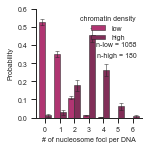

In [22]:
fig,axes = plt.subplots()
protein = 'NUC'
_plot_df.groupby(['number_NUC','density'])['probability'].sum().unstack().iloc[:, ::-1].plot(kind='bar', width=0.8, ax=axes,figsize=(1.91,2), 
                   lw=0.5, edgecolor='.15',color=[sns.desaturate(palettes[protein][1],0.75),sns.desaturate(palettes[protein][3],0.75)],
                   error_kw=dict(ecolor='.15', lw=0.5, capsize=2, capthick=0.5),
                   yerr=_plot_df.groupby(['number_NUC','density'])['standard_error'].sum().unstack())
axes.set_ylim(0,0.6)
axes.set_xlabel('# of nucleosome foci per DNA')
axes.set_ylabel('Probability')

axes.legend([f"low (n = {int(df_nuc.sum()['50x'])})",
             f"high (n = {int(df_nuc.sum()['75x'])})"],loc=0,frameon=False)
plt.xticks(rotation=0)

axes.text(0.95, 0.7, f"n-low = {_plot_df[_plot_df['density']=='low']['nobs'].max()}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,
        color='.15')
axes.text(0.95, 0.6, f"n-high = {_plot_df[_plot_df['density']=='high']['nobs'].max()}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,
        color='.15')

plt.legend(title='chromatin density', frameon=False,loc=1)
sns.despine()
plt.savefig(dir_out+'S4B_NUC_foci_DNA_errorbars.svg',transparent=True)


### Figure S4C: NUC distribution on DNA - low density

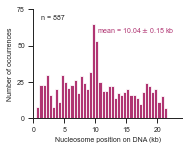

In [23]:
protein = "NUC"
pal_pos = 1

fig,axes = plt.subplots()

sns.distplot(df[df['chromatin']=='50x'].filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000,
             label=f'{protein} loading site', ax=axes,
             color=sns.desaturate(palettes[protein][pal_pos],0.75) ,bins = np.linspace(0, 25, 51), kde=False, hist_kws={'alpha':1})
# mean+/- sem
mean_start = pd.melt(df.filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000)['value'].median()
sem_start = pd.melt(df.filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000)['value'].sem()
axes.text(0.95, 0.85, f"mean = {round(mean_start,2)} $\pm$ {round(sem_start,2)} kb",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,color=sns.desaturate(palettes[protein][pal_pos],0.75))

axes.set_xlim(0,24)
axes.set_ylim(0,75)
axes.set_yticks([0,25,50,75])
axes.set_xlabel('Nucleosome position on DNA (kb)')
axes.set_ylabel('Number of occurrences')

#axes.set_title(f'{protein} distribution on DNA')

axes.text(0.05, 0.95, f"n = {len(pd.melt(df[df['chromatin']=='50x'].filter(regex=(protein+'_'),axis=1).xs('start_site',level='properties',axis=1))['value'].dropna())}",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes)

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S4C_NUC_distribution_DNA.svg',transparent=True)